In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import pyntcloud
from pyntcloud import PyntCloud
import scipy
from sklearn.neighbors import NearestNeighbors
import src.realsense.dataset as rld
import src.realsense.camera as rlc
import src.visual3d.geometry as geom
import rosbag
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

print("Environment Ready")

# %matplotlib
%load_ext autoreload
%autoreload 2

Environment Ready


In [2]:
data = pd.read_csv("data/colours_rgb_shades.csv", usecols = [1,2,3,4])
data.head()

numpied_data = data.to_numpy()[:,:3]
# print("Numpied Data : ", numpied_data)

numpied_vals = data.to_numpy()[:,-1:].reshape(-1)
# print("NUmpied Values : ", numpied_vals)

model = RandomForestClassifier()
model.fit(numpied_data, numpied_vals)

# test = np.array([[229, 193, 245]])
# yhat = model.predict(test)
# print(yhat)

RandomForestClassifier()

In [32]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("data/with_objects_multi_layer.bag")
profile = pipe.start(cfg)
playback = profile.get_device().as_playback()
playback.set_real_time(False)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(205):
    pipe.wait_for_frames()

# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


shape of rgb = (720, 1280, 3)
shape of colorized_depth = (480, 848, 3)


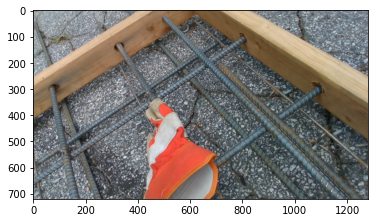

In [33]:
# visualize the capture frame

color = np.asanyarray(color_frame.get_data())
print(f"shape of rgb = {color.shape}")

colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
print(f"shape of colorized_depth = {colorized_depth.shape}")
H,W = color.shape[:2]

gray = np.mean(colorized_depth,axis=2).astype(np.uint8)
plt.imshow(color)

0.0010000000474974513
shape of colorized_depth = (720, 1280, 3)


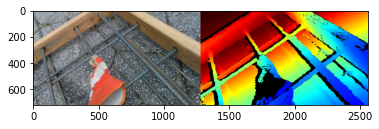

In [34]:
# align rgb and depth image

align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())


# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)
# plt.imshow(colorized_depth_cp)

depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
print(depth_scale)

depth = np.asanyarray(aligned_depth_frame.get_data())
depth = depth*depth_scale
# depth[depth<0.001] = depth.max
print(f"shape of colorized_depth = {colorized_depth.shape}")




In [35]:
# get intrinsics

bag = rosbag.Bag('data/with_objects_multi_layer.bag')
count_loop = 0
for topic, msg, t in bag.read_messages():
    if 'Color_0/info/camera_info' in topic:
        K = msg.K
    count_loop +=1
    if count_loop > 20:
        break
bag.close()

K = np.array(K).reshape(3,3)
print(f"Obtained the intrinsics: K= \n{K}")

Obtained the intrinsics: K= 
[[915.69732666   0.         627.21875   ]
 [  0.         914.33947754 349.1913147 ]
 [  0.           0.           1.        ]]


In [36]:
# simple plane segmentation

from sklearn import linear_model
xyz,rgb = rlc.project_rgbd2pcd(color,depth,K) # project to point cloud
idx = xyz[:,2]>0.001
xyz = xyz[idx,:]; rgb = rgb[idx,:]

xy = xyz[:,:2]; z=xyz[:,2]
reg = linear_model.LinearRegression()
reg.fit(xy,z)

print(f"plane: z = {reg.coef_[0]}x + {reg.coef_[1]}y + {reg.intercept_} ")
class_binary = (z - (xy @ reg.coef_ + reg.intercept_) ) < -0.030

plane: z = -0.4071175998188279x + -0.711721287469202y + 0.5283838287063483 


In [37]:
# Visualize the slicing result
xyz_top = xyz[class_binary,:]
rgb_top = rgb[class_binary,:]
xyz_bottom = xyz[~class_binary,:]
rgb_bottom = rgb[~class_binary,:]


class_binary_color = model.predict(rgb_top) == 1
xyz_filtered = xyz_top[class_binary_color,:]
rgb_filtered = rgb_top[class_binary_color,:]

pd = geom.PointCloud(xyz=xyz_top)
pd.rgb = rgb_top
pd.add(geom.PointCloud(xyz=xyz_bottom,color='red'))
pd.show()


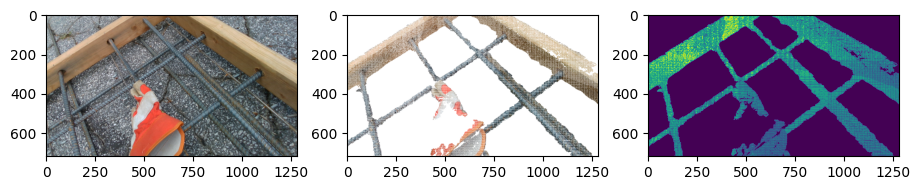

In [38]:
color_top, depth_top = rlc.project_pcd2rgb(xyz_top,rgb_top,H,W,K)
# images = np.hstack((color,color_top))
plt.figure(figsize=(11,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(131);plt.imshow(color)
plt.subplot(132);plt.imshow(color_top)
plt.subplot(133);plt.imshow(depth_top)

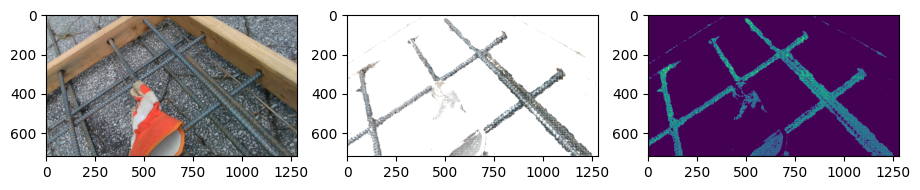

In [43]:
# # Projecting the top-only layer

color_top, depth_top = rlc.project_pcd2rgb(xyz_filtered,rgb_filtered,H,W,K)
# color_top, depth_top = rlc.project_pcd2rgb(xyz_top,rgb_top,H,W,K)
# images = np.hstack((color,color_top))
plt.figure(figsize=(11,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(131);plt.imshow(color)
plt.subplot(132);plt.imshow(color_top)
plt.subplot(133);plt.imshow(depth_top)

(88801, 2)


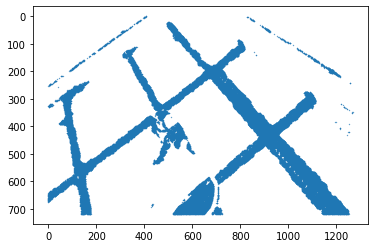

In [44]:
x_idx = np.array([range(W) for _ in range(H)])
y_idx = np.array([range(H) for _ in range(W)]).T
binary_depth = depth_top > 0.001
gmm_x = x_idx[binary_depth].reshape(-1)
gmm_y = y_idx[binary_depth].reshape(-1)
gmm_xy = np.c_[gmm_x,gmm_y]
plt.scatter(gmm_xy[:,0],gmm_xy[:,1],s=0.1); 
plt.gca().invert_yaxis()
print(gmm_xy.shape)

Points :  [756.189568030725, 86.30187467648886] [150.160603048392, 603.754236279271]
Points :  [1093.1173017595258, 677.764653679473] [301.9270468054883, 612.6045613261592]
Points :  [83.25987121141631, 147.39396240667907] [279.68641676601095, 680.3862871190081]
Points :  [318.86157364380995, 492.3002357853494] [141.21000244614726, 363.4665201064346]
Points :  [1063.234872454572, 619.490315929944] [565.5325506312254, 144.77509900263053]


C:\Users\Dell\anaconda3\envs\skymul\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\Users\Dell\anaconda3\envs\skymul\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


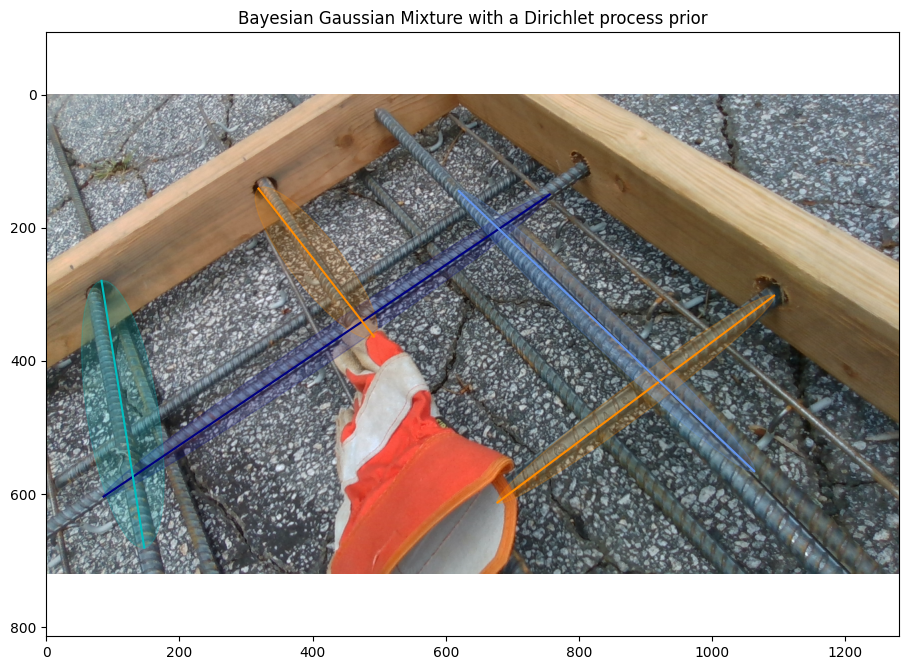

In [45]:
# GMM prediction

import itertools
from scipy import linalg
import matplotlib as mpl

from sklearn import mixture



color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
            
        if v[1]/v[0]<3.5:
            continue
    
#         plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)
        
        p0 = mean - np.array([u[0],u[1]])*v[0]/(2.0 )
        p1 = mean + np.array([u[1],u[1]])*v[0]/(2.0 )
        p2 = mean - np.array([u[1],-u[0]])*v[1]/(2.0 )
        p3 = mean + np.array([u[1],-u[0]])*v[1]/(2.0 )    
        plt.plot([p2[0],p3[0]],[p2[1],p3[1]],color=color)
        print("Points : ", [p2[0],p3[0]],[p2[1],p3[1]])
        
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.2)
        splot.add_artist(ell)
        plt.axis('equal')
        plt.xlim([0,1280])
        plt.ylim([0,720])


    plt.title(title)
    
X = gmm_xy[::20,:]
dpgmm = mixture.BayesianGaussianMixture(n_components=30, covariance_type="full").fit(X)
plt.figure(figsize=(11,8), dpi= 100, facecolor='w', edgecolor='k')
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    0,
    "Bayesian Gaussian Mixture with a Dirichlet process prior",
)

plt.gca().invert_yaxis()

plt.subplot(111)
plt.imshow(color)

[[130.35435638 573.92546733]
 [679.75375555 201.91673805]
 [921.00140485 430.66714105]]


C:\Users\Dell\anaconda3\envs\skymul\lib\site-packages\ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


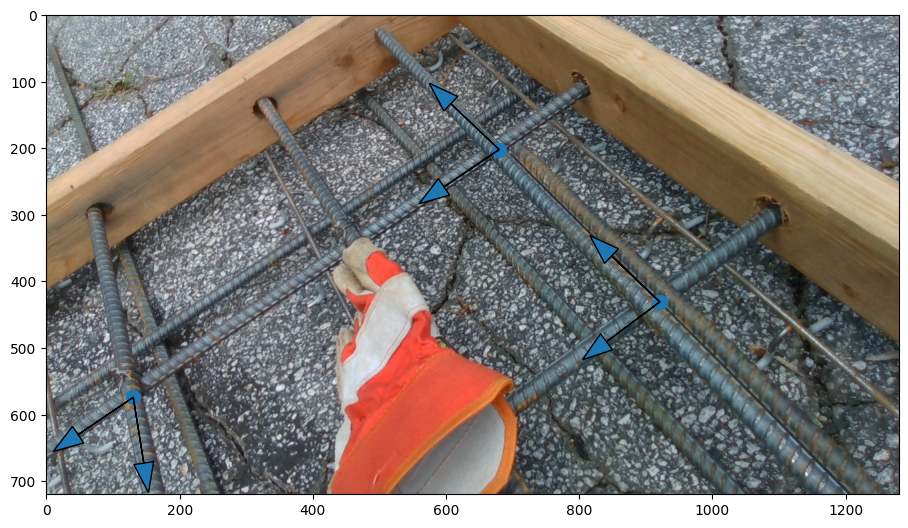

In [47]:
# obtain lines & intersections
from sklearn import linear_model

lines = []
for i, (mean, covar) in enumerate(zip(dpgmm.means_,  dpgmm.covariances_)):
    v, w = linalg.eigh(covar)
    v = np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    if not np.any(dpgmm.predict(X) == i):
        continue
    if v[1]/v[0]<3.5:
        continue
    p2 = mean - np.array([u[1],-u[0]])*v[1]
    p3 = mean + np.array([u[1],-u[0]])*v[1]  
    lines.append((p2,p3))

intersections = []
vectors1 = []
vectors2 = []
vectors3d_1 = []
vectors3d_2 = []
for i in range(len(lines)):
    for j in range(i+1,len(lines)):
        (x1,y1),(x2,y2) = lines[i]
        (x3,y3),(x4,y4) = lines[j]
        px = ((x1*y2-y1*x2)*(x3-x4) - (x1-x2)*(x3*y4-y3*x4)) / ((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
        py = ((x1*y2-y1*x2)*(y3-y4) - (y1-y2)*(x3*y4-y3*x4)) / ((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))   
        thres = 100
        m1 = (y1-y2)/(x1-x2)
        m2 = (y3-y4)/(x3-x4)
        if px < max(min(x1,x2),min(x3,x4))-thres or px > min(max(x1,x2),max(x3,x4))+thres:
            continue
       
        
        elif 0 < abs(m1-m2) and abs(m1-m2) < 0.16:
            
            continue
            
        elif px < color.shape[1] and py < color.shape[0] and int(model.predict(np.array(color[int(py), int(px), :]).reshape(1,3))) == 0:
            
            continue
            
        else:
            # 2d space
            intersections.append([px,py])
            v1 = np.array([x2-x1,y2-y1]); v1 = v1/np.linalg.norm(v1)
            v2 = np.array([x4-x3,y4-y3]); v2 = v2/np.linalg.norm(v2)
            vectors1.append(v1); vectors2.append(v2)
            
            # 3d space
#             u1 = np.linspace(x1,x2,num=100).astype(np.int)
#             v1 = np.linspace(y1,y2,num=100).astype(np.int)
#             d1 = depth_top[v1,u1]
#             xyz1 = rlc.project_pixel2pcd(u1,v1,d1,K)
#             x1 = xyz1[:,0];y1 = xyz1[:,1];z1 = xyz1[:,2];t1 = np.arange(len(x1)).reshape(-1,1)
#             ransac = linear_model.RANSACRegressor();ransac.fit(t1, x1);kx1 = ransac.estimator_.coef_
#             ransac = linear_model.RANSACRegressor();ransac.fit(t1, y1);ky1 = ransac.estimator_.coef_
#             ransac = linear_model.RANSACRegressor();ransac.fit(t1, z1);kz1 = ransac.estimator_.coef_
#             vector1 = np.array([kx1,ky1,kz1]); vector1 = vector1/np.linalg.norm(vector1);
#             vectors3d_1.append(vector1)
            
#             u2 = np.linspace(x3,x4,num=100).astype(np.int)
#             v2 = np.linspace(y3,y4,num=100).astype(np.int)
#             d2 = depth_top[v2,u2]
#             xyz2 = rlc.project_pixel2pcd(u2,v2,d2,K)
#             x2 = xyz2[:,0];y2 = xyz2[:,1];z2 = xyz2[:,2];t2 = np.arange(len(x2)).reshape(-1,1)
#             ransac = linear_model.RANSACRegressor();ransac.fit(t2, x2);kx2 = ransac.estimator_.coef_
#             ransac = linear_model.RANSACRegressor();ransac.fit(t2, y2);ky2 = ransac.estimator_.coef_
#             ransac = linear_model.RANSACRegressor();ransac.fit(t2, z2);kz2 = ransac.estimator_.coef_
#             vector2 = np.array([kx2,ky2,kz2]); vector2 = vector2/np.linalg.norm(vector2);
#             vectors3d_2.append(vector2)
            

intersections = np.array(intersections)
print(intersections)

plt.figure(figsize=(11,8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(intersections[:,0],intersections[:,1],100)
for (px,py),(v1x,v1y),(v2x,v2y) in zip(intersections,vectors1,vectors2):
    vlength = 100
    plt.arrow(px,py,vlength*v1x,vlength*v1y,head_width=30)
    plt.arrow(px,py,vlength*v2x,vlength*v2y,head_width=30)


plt.gca().invert_yaxis()

plt.subplot(111)
plt.imshow(color)